# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [ ]:
# Install colabgymrender to display gym environments in Colab
!pip install gym[box2d] > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender > /dev/null 2>&1
!pip install imageio==2.4.1 > /dev/null 2>&1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder

First we create the environment:

In [ ]:
env = gym.make('CarRacing-v2') # Create environment
#test

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [ ]:
s = env.reset(options={"randomize": False})
a = env.action_space.sample()
print('State space shape:', s.shape)
print(f'Action space: [Steering, gas, breaking] - ', a )

State space shape: (96, 96, 3)
Action space: [Steering, gas, breaking] -  [0.240636   0.36909604 0.36674297]


State space shape: (96, 96)


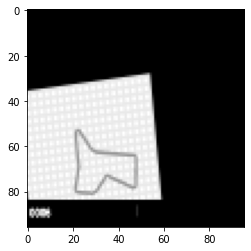

In [ ]:
type(s)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

s_g = rgb2gray(s)
print('State space shape:', s_g.shape)
plt.imshow(s_g, "gray")

In [ ]:
action = env.action_space.sample()
print(f'Action [Steering, gas, breaking] - {action}')
type(action)

Action [Steering, gas, breaking] - [-0.19393705  0.13104334  0.00668602]


numpy.ndarray

In [ ]:
state, reward, done, info = env.step(action)

# Grayscaling the image
print('State space shape:', state.shape)
state = rgb2gray(state)
print('State space shape:', state.shape)

print(f'Reward: {reward}')
print(f'done: {done}')
print(f'Info: {info}')

State space shape: (96, 96, 3)
State space shape: (96, 96)
Reward: -0.09999999999999964
done: False
Info: {}


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [ ]:
env = gym.make('CarRacing-v2') # Create environment
env = Recorder(env, "./video") # To display environment in Colab
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "



[0.3569433  0.261979   0.80916643]
[-0.3033246   0.8122343   0.21693166]
[-0.6080803   0.06638324  0.19782043]
[-0.96354973  0.6254092   0.47296545]
[-0.7699814   0.61383736  0.8926008 ]
[0.6154161  0.47700775 0.09810133]
[-0.3325999   0.39674687  0.86068594]
[0.8822922  0.5952951  0.19259237]
[0.6945101  0.7192458  0.85503274]
[-0.19725682  0.08138455  0.6057043 ]
[-0.19875182  0.60895294  0.82509017]
[-0.08657853  0.48090866  0.09219115]
[0.78826874 0.3879917  0.45990807]
[-0.75728786  0.84323865  0.6626318 ]
[0.6936597  0.30290365 0.5232203 ]
[-0.3720109   0.9704715   0.87370193]
[0.16473421 0.97694653 0.03136807]
[0.71441716 0.19432198 0.8997094 ]
[0.50213736 0.12338244 0.7138366 ]
[-0.56430465  0.9570879   0.96911544]
[0.5860545  0.08429215 0.42336592]
[-0.38925934  0.5141534   0.9551371 ]
[0.10770102 0.2410483  0.21103765]
[0.987127   0.42137954 0.1944519 ]
[0.00650356 0.5169666  0.9587879 ]
[-0.02382546  0.6291071   0.582331  ]
[0.06976633 0.891712   0.8766448 ]
[-0.9441589   0.

KeyboardInterrupt: ignored

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [ ]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        print(f'x_shape inside forward {x.shape}')
        x = self.hidden(x)
        x = F.tanh(x)
        x = self.out(x)
        return x
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [ ]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [ ]:
n_inputs = 96**2 #TODO
n_hidden = 20
print(env.action_space)
n_outputs = 3 #TODO

print('state shape:', n_inputs)
print('action shape:', n_outputs)

Box([-1.  0.  0.], 1.0, (3,), float32)
state shape: 9216
action shape: 3


In [ ]:
def inputsize_correct(s):
    s = np.expand_dims(s.flatten(), axis=0)
    s = torch.from_numpy(np.atleast_2d(s)).float()
    return s

# training settings

num_episodes = 10
rollout_limit = 20 # max rollout length
discount_factor = 0.98 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.004 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        s = rgb2gray(s)
        s = inputsize_correct(s)
        print(f's_shape inside forward {s.shape}')
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(s)
                #a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
                a = a_prob.squeeze().numpy()
                a[0] = min(max(-1, a[0]),1)
                a[1] = min(max(0, a[1]), 0.99999)
                a[2] = min(max(0, a[2]), 0.9999)
            s1, r, done, _ = env.step(a)
            s1 = rgb2gray(s1)
            s1 = inputsize_correct(s1)
            rollout.append((s, a, r)) # state - action - reward
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0] )
        print(f'shape of states: {states.shape}\n{rollout[1,0].shape}')
        actions = np.vstack(rollout[:,1])
#        print(f'Actions: {actions}')
        rewards = np.array(rollout[:,2], dtype=float) #- (d_from_mid *0.1)
        returns = compute_returns(rewards, discount_factor)
#        print(f'returns: {returns}')
        # policy gradient update
        policy.optimizer.zero_grad()
        #             print(f'Actions in the outer loop: {torch.from_numpy(states).float().shape}')
        a_probs = policy(torch.from_numpy(states).float())#.gather(1, torch.from_numpy(actions)).view(-1)
        print(f'Actions in the outer loop: {a_probs}')
        print(f'Actions in the outer loop (gather): {a_probs.gather(1, torch.from_numpy(actions))}')
        print(f'Actions in the outer loop (view): {a_probs.gather(1, torch.from_numpy(actions)).view(-1)}')
#        print(f'a_probs: {a_probs}')
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                s = rgb2gray(s)
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(s)
                        #a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
                        a = a_prob.squeeze().numpy()
                        a[0] = min(max(-1, a[0]),1)
                        a[1] = min(max(0, a[1]), 0.99999)
                        a[2] = min(max(0, a[2]), 0.9999)
                    s1, r, done, _ = env.step(a)
                    s1 = rgb2gray(s1)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')  

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



start training
s_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])
x_shape inside forward torch.Size([1, 9216])


x_shape inside forward torch.Size([1, 9216])
shape of states: (20, 9216)
torch.Size([1, 9216])
states in the outer loop: torch.Size([20, 9216])
x_shape inside forward torch.Size([20, 9216])
states in the outer loop: tensor([[ 0.6594, -0.8258,  0.5227],
        [ 0.5326, -0.2179, -0.4176],
        [-0.0663, -0.8175, -0.9886],
        [ 0.6741, -0.8690, -0.7586],
        [ 0.4101, -0.4783, -1.0443],
        [ 0.6597, -0.8392, -0.7663],
        [ 0.2326, -1.2244, -0.7210],
        [ 0.2358, -1.2279, -0.7090],
        [-0.1833, -1.0481, -1.1627],
        [-0.1833, -1.0481, -1.1627],
        [-0.4321, -0.6088, -0.9511],
        [-0.5175, -0.4107, -0.8762],
        [-0.4098, -0.5122, -0.4476],
        [-0.4100, -0.5098, -0.4536],
        [-0.5160, -0.4096, -0.8758],
        [-0.1074, -0.0496, -0.9161],
        [-0.0864, -0.0310, -0.9182],
        [-0.0864, -0.0310, -0.9182],
        [-0.0864, -0.0310, -0.9182],
        [-0.0864, -0.0310, -0.9182]], grad_fn=<AddmmBackward0>)


RuntimeError: ignored

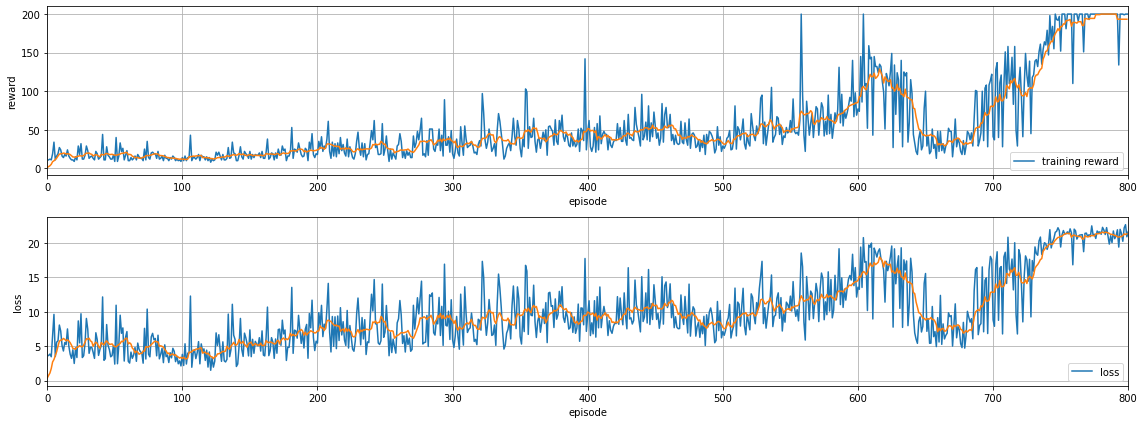

In [ ]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [ ]:
env = Recorder(env, "./gym-results") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
# env.close()
env.play()

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  result = np.fromstring(s, dtype='uint8')



## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

The learning rate was upped, to make it faster to converge, as the original wasn't even getting the max score within the 800 episodes.<br>
Played around with the discount factor, where the optimal was between 0.97-0.99.<br>
This was enoguh to make the model perform as well as the simulation model allowed it to, meaning that it blanced the pole for 6 seconds, which as a stopping criteria for the simulation.<br>
I tried to punish the model for being farther away from the middle point, but this didn't work.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

The total reward for the 10 timesteps is 5.<br>
The future rewards in each timestep is; [0, 1, 2, 3, 3, 4, 5, 5, 5, 5].<br>
The discounted future reward in each timestep is; [0, 0.9, 1.7, 2.4, 2.4, 3.0, 3.6, 3.6, 3.6, 3.6].

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

In the validation calculation, the action set with the highest probablity is chosen. For the training set, the mean of each action set is taken, where the discount factor has been taken into account.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

It is taking the average reward and drawing from the distribution with that value, instead of just choosing the action set which resulted in the best reward. This way we get a sense of exploration, especially in the start, but as we continue going we opt towards exploitation.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*